In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from math import sqrt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE

import pickle
import shap



# Problem description

This project analyzes a dataset from a Portuguese banking institution's marketing campaign.
The goal is to build classification models to predict whether a customer will subscribe to a term deposit.

The dataset consists of 16 input variables related. Here is a summary of the composition of the dataset:

1. Age: Numeric variable representing the age of the bank client.
2. Job: Categorical variable indicating the type of job the client has.
3. Marital: Categorical variable indicating the marital status of the client.
4. Education: Categorical variable indicating the educational background of the client.
5. Default: Binary variable indicating whether the client has credit in default.
6. Balance: Numeric variable representing the average yearly balance of the client in euros.
7. Housing: Binary variable indicating whether the client has a housing loan.
8. Loan: Binary variable indicating whether the client has a personal loan.
9. Contact: Categorical variable indicating the type of contact communication used.
10. Day: Numeric variable representing the last contact day of the month.
11. Month: Categorical variable representing the last contact month of the year.
12. Duration: Numeric variable representing the duration of the last contact in seconds.
13. Campaign: Numeric variable indicating the number of contacts performed during the current campaign.
14. Pdays: Numeric variable indicating the number of days that passed since the client was last contacted from a previous campaign.
15. Previous: Numeric variable indicating the number of contacts performed before the current campaign.
16. Poutcome: Categorical variable indicating the outcome of the previous marketing campaign.

The dataset contains 43,907 observations, each representing a phone call made during the marketing campaigns of the banking institution.

# Data Ingestion

In [2]:
df= pd.read_csv("./data/bank-dataset.csv")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261.0,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151.0,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76.0,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92.0,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,unknown,5,may,198.0,1,-1,0,unknown,no


# Data Exploration and Data Cleaning

Let's start by looking at some descriptive statistics.

In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,43074.000000,43097.000000,43097.000000,43021.000000,43097.000000,43097.000000,43097.000000
mean,41.297674,1342.323596,15.858157,244.533251,2.796622,38.725155,0.550154
std,12.240857,2990.087062,8.429079,239.982705,3.144191,98.700477,2.280486
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,67.000000,8.000000,100.000000,1.000000,-1.000000,0.000000
50%,39.000000,437.000000,16.000000,174.000000,2.000000,-1.000000,0.000000
75%,48.000000,1400.000000,21.000000,303.000000,3.000000,-1.000000,0.000000
max,150.000000,102127.000000,99.000000,4918.000000,63.000000,871.000000,275.000000


From this descriptive statistics, it is evident that some data cleaning is necessary. For instance, the column "Age" exhibits a maximum value of 150, which is impossible and requires investigation. Similarly, the column "Day" has a maximum value of 99, whereas it should  range between 0 and 31. These discrepancies indicate the need for data cleaning and validation to ensure the accuracy and integrity of the dataset.

In [5]:
num_errors_age=df[df.age>100]["age"].value_counts()
num_errors_day=df[df.day>31]["day"].value_counts()
print(f"Number of errors in 'age' column: {num_errors_age.iloc[0]}")
print(f"Number of errors in 'day' column: {num_errors_day.iloc[0]}")

Number of errors in 'age' column: 157
Number of errors in 'day' column: 13



Since there are only a few rows with errors in the 'age' and 'day' columns, I have decided to drop those rows from the dataset.

In [6]:
df=df[df.age<100]
df=df[df.day<=31]

In [7]:
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,42904,42904,42904,42904,42904,42904,42846,42904,42894,42904
unique,12,7,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9429,26040,22129,42105,24276,35858,27457,13337,35455,39780


Additionally, I have observed that certain categorical variables have a higher number of unique values compared to the actual classes defined for those specific columns. This suggests the presence of misspelled or inconsistent values within the dataset.

In [8]:
label_legend={"job":["admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services"],
              "marital":["married","divorced","single"],
              "education":["unknown","secondary","primary","tertiary"],
              "default":["yes","no"],
              "housing":["yes","no"],
              "loan":["yes","no"],
              "contact":[ "unknown","telephone","cellular"],
              "month":["jan", "feb", "mar", "apr","may","jun","jul","aug","sep","oct","nov", "dec"],
              "poutcome":["unknown","other","failure","success"]}


for col, label in label_legend.items():
    mispelled_label=set(df[col])-set(label)
    if not mispelled_label:
        print(f"Columns {col} doesn't have mispelled data")
    else:
        print(f"Columns {col} has mispelled data: {mispelled_label}")

Columns job doesn't have mispelled data
Columns marital has mispelled data: {'divrcd', 'S', 'Single', 'Singl'}
Columns education doesn't have mispelled data
Columns default doesn't have mispelled data
Columns housing doesn't have mispelled data
Columns loan doesn't have mispelled data
Columns contact has mispelled data: {nan}
Columns month doesn't have mispelled data
Columns poutcome has mispelled data: {nan}


In [9]:
corrections={"divrcd":"divorced","Single":"single","S":"single","Singl":"single"}
df.marital.replace(corrections,inplace=True)
df['contact'] = df['contact'].fillna('unknown')
df['poutcome'] = df['poutcome'].fillna('unknown')

Now, let's conduct an investigation to determine the presence of any nan values in the dataset.

In [10]:
nan_columns = df.isnull().any()
columns_with_nan = nan_columns[nan_columns].index.tolist()

for col in columns_with_nan:
    total_nan = df[col].isnull().sum()

    # Calculate the percentage of NaN values in the 'age' column
    percentage_nan = (total_nan / len(df[col])) * 100

    # Print the results
    print(f"Number of NaN values in the {col} column: {total_nan}")
    print(f"Percentage of NaN values in the {col} column: {percentage_nan:.2f}%")

Number of NaN values in the duration column: 76
Percentage of NaN values in the duration column: 0.18%



Since the number of missing values is relatively small compared to the total number of observations, I have decided to drop those missing values from the dataset.

In [11]:
df.dropna(inplace=True)

Let's now examine the distribution of the variables 'Age', 'Balance', as well as their relationship with the target variable.

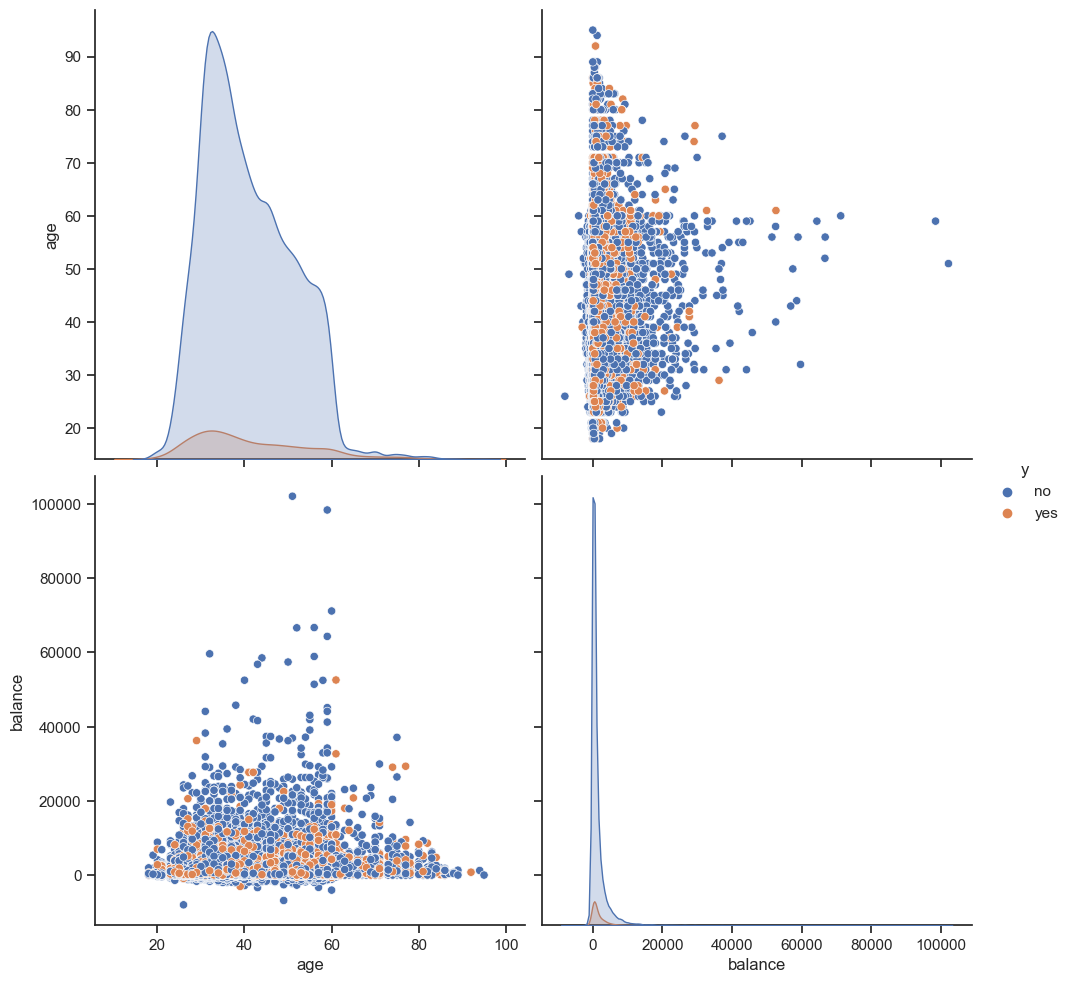

In [12]:
columns = ["age", "balance","y"]
sns.set(style="ticks")
sns.pairplot(df[columns],hue="y",height=5)
plt.show()

Upon examining the pairplot, it is not evident that there is a discernible relationship between the variables 'age' and 'balance' and the output variable. Let's investigate whether there is any presence of multicollinearity in the dataset.

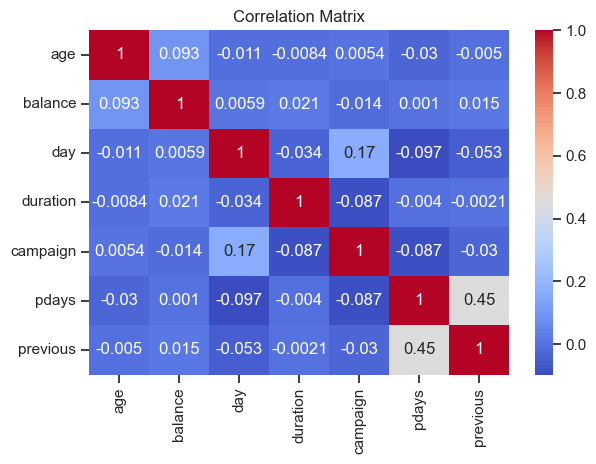

In [13]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

There does not appear to be a strong correlation among the input variables in the dataset.
Now, let's explore the relationship between the target variable and the categorical variables in the dataset.

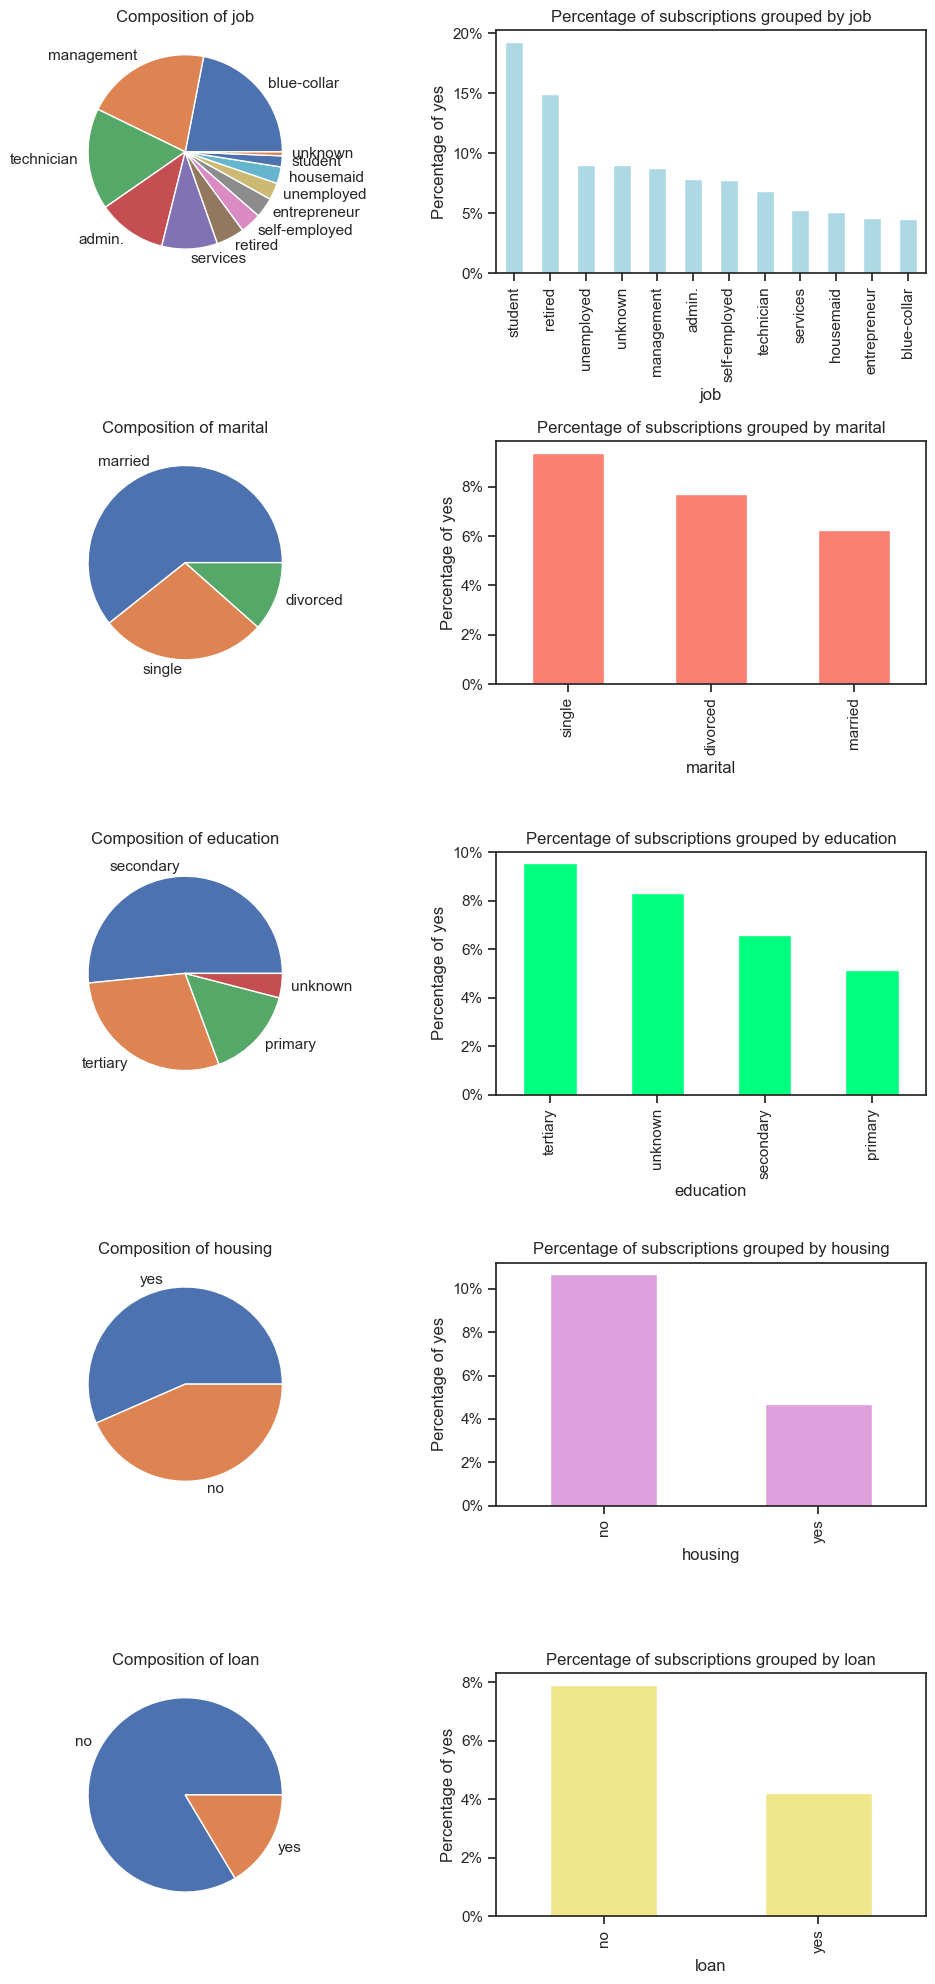

In [14]:
variables = ["job", "marital", "education", "housing", "loan"]
colors = ["lightblue", "salmon", "springgreen", "plum", "khaki"]

fig, axes = plt.subplots(5,2,figsize=(10,20))
i=0
for var, color in zip(variables,colors):

    axes[i, 0].set_title(f"Composition of {var}")
    var_counts = df[var].value_counts()
    var_counts.plot(kind="pie", ax=axes[i,0])
    axes[i, 0].set_ylabel('')
    axes[i, 1].set_title(f"Percentage of subscriptions grouped by {var}")
    cross_tab = pd.crosstab(df[var], df["y"], normalize="index")
    cross_tab=cross_tab.sort_values(by=["yes"],ascending=False)
    cross_tab["yes"].plot(kind="bar", stacked=False, ax=axes[i,1],color=color)
    axes[i, 1].set_ylabel("Percentage of yes")
    axes[i, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
    i=i+1

plt.tight_layout()
plt.show()

The plot suggests that individuals who do not have any existing loans and those who are single are more likely to subscribe to term deposits. Additionally, it appears that students and retired individuals, who can be categorized as younger or older people respectively, also show a higher tendency to subscribe.Additionally, the plot suggests that individuals with higher education levels also show a higher propensity to subscribe to term deposits.

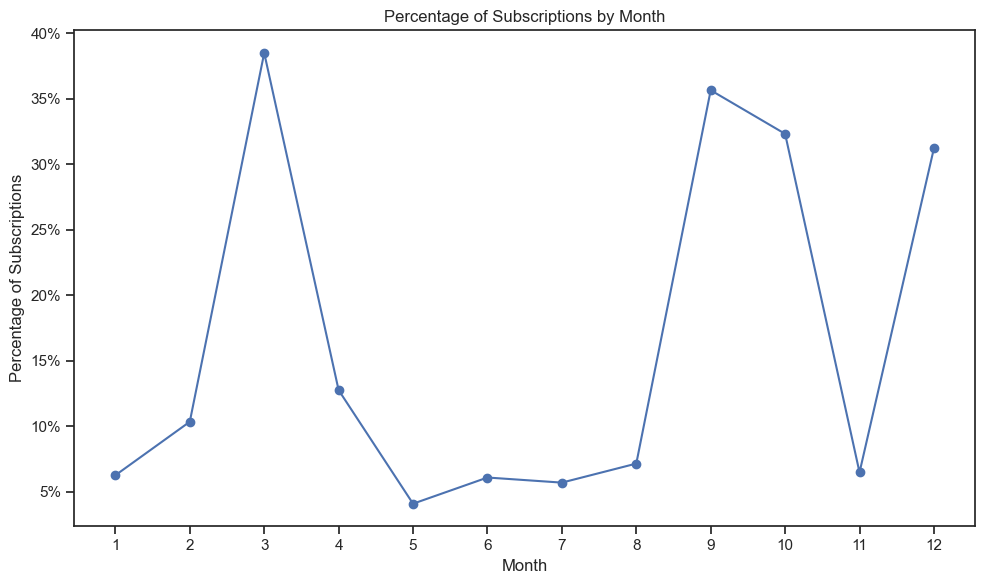

In [15]:

month_mapping={'apr':4,'aug':8,'dec':12,'feb':2,'jan':1,'jul':7,'jun':6,'mar':3,'may':5,'nov':11,'oct':10,'sep':9}
df["month"] = df.month.map(month_mapping)

month_counts = df.groupby(['month'])['y'].value_counts(normalize=True).unstack()
month_percentages = month_counts['yes'] 

plt.figure(figsize=(10, 6))
plt.plot(month_percentages.index, month_percentages.values, marker='o')
plt.xlabel('Month')
plt.ylabel("Percentage of Subscriptions")
plt.title('Percentage of Subscriptions by Month')
plt.xticks(month_percentages.index)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
plt.show()


The analysis of the data suggests that the timing of the marketing proposal plays a significant role in the decision-making process of clients regarding term deposit subscriptions. Specifically, the months of March, September, October, and December exhibit higher percentages of subscription rates compared to other months.

Let's take a look at the distribution of the response variable.

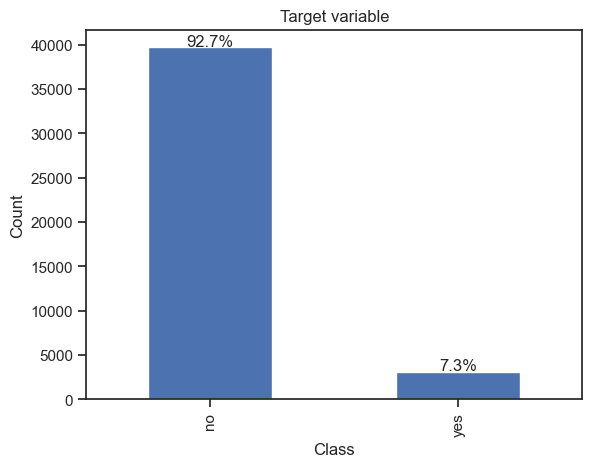

In [16]:
class_counts = df['y'].value_counts()
class_percentages = df['y'].value_counts(normalize=True) * 100

class_counts.plot(kind='bar')

percentage = class_percentages["yes"]
plt.annotate(f'{percentage:.1f}%', (1, class_counts["yes"]), xytext=(0, 1),
                textcoords='offset points', ha='center')
percentage = class_percentages["no"]
plt.annotate(f'{percentage:.1f}%', (0,  class_counts["no"]), xytext=(0, 1),
                textcoords='offset points', ha='center')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Target variable')
plt.show()

The dataset exhibits a significant class imbalance, which is an important factor to consider during the model construction process.

# Data Preprocessing and Feature Selection

 I have chosen to focus solely on the client's personal information rather than considering data from previous calls. This decision is based on the belief that the model should be able to anticipate whether a client will subscribe to a term deposit without any prior interaction. By doing so, the bank can directly target individuals who are more likely to subscribe, allowing for more effective allocation of resources.

In [17]:
df=df[["age","job","marital","education","default","balance","housing","loan","y"]]

Since there are a small number of "unknown" values present in some of the categorical variables, which can be considered as similar to NaN values, I have chosen to drop these observations. 

In [18]:
unknown_counts = df.apply(lambda x: x.value_counts().get('unknown', 0))
print(unknown_counts)
df=df[(df.job!="unknown") & (df.education!="unknown")]


age             0
job           278
marital         0
education    1731
default         0
balance         0
housing         0
loan            0
y               0
dtype: int64



I have also removed any duplicate entries from the dataset

In [19]:
df=df.drop_duplicates()

To prepare the categorical variables for machine learning models, I performed specific transformations to convert them into a numeric representation. For the "job" and "marital" variables, I applied a technique called one-hot encoding. This process created binary columns for each unique category within these variables, indicating the presence or absence of a specific category for each observation.

On the other hand, for the "education" variable, I used ordinal encoding. This approach assigned numeric values to each category based on their order or hierarchy. By encoding the categories in a meaningful order, the model can capture any inherent relationship or order between the education levels.

For the binary variable, I applied a simple mapping where "Yes" was assigned the value 1 and "No" was assigned the value 0. 

In [20]:
binary_mapping = {"yes": 1, "no": 0}
for column in df.columns:
    if set(df[column].unique()) == {"yes", "no"}:
        df[column] = df[column].replace(binary_mapping)
        
education_mapping = {'primary': 1, 'secondary': 2,'tertiary':3}
df["education"] = df["education"].replace(education_mapping)
df=pd.get_dummies(df)


In [21]:
df.head()

,age,education,default,balance,housing,loan,y,job_admin.,job_blue-collar,job_entrepreneur,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
0,58.0,3,0,2143,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,44.0,2,0,29,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,33.0,2,0,2,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,35.0,3,0,231,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
6,28.0,3,0,447,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# Model Development

In [22]:
# Function used to easily plot confusion matrix
def plot_confusion_matrix(confusion_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

To begin, I have splitted the data into a training set and a test set. This division is important to evaluate the performance of the models on unseen data and avoid overfitting.

In [23]:
X=df.drop(columns="y")
y=df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

To establish a baseline for the model, I started by fitting two models: a random forest and a logistic regression.

In [24]:
classifiers = [
    ('Random_Forest', RandomForestClassifier(random_state=2)),
   ('Logistic_Regression', LogisticRegression(max_iter=1000)),
]


df_performance_results=pd.DataFrame(columns=["Accuracy","Balanced Accuracy","Sensitivity","Specificity","GM_score","F1-score"])

best_model_cm={}
for model_name, model in classifiers:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred,pos_label=0)
        f1 = f1_score(y_test, y_pred)
        gm_score = sqrt(sensitivity*specificity)

        df_performance_results.loc[model_name]=[accuracy,balanced_accuracy,sensitivity,specificity,gm_score,f1]
        cm = confusion_matrix(y_test, y_pred)
        best_model_cm[model_name]=cm



The table below displays the results of the two models on the test data. Considering the highly unbalanced nature of the dataset, it is not advisable to rely solely on accuracy as a performance metric. High accuracy can be misleading in such cases, as models can simply predict everything as the majority class, disregarding the minority class. This behavior is evident from the confusion matrix of the logistic regression model, which classifies everything as negative. Therefore, despite the high accuracy, these models may not be useful. Instead, a more suitable metric to consider in this scenario is the F1 score.

In [25]:
df_performance_results

,Accuracy,Balanced Accuracy,Sensitivity,Specificity,GM_score,F1-score
Random_Forest,0.908419,0.513218,0.050909,0.975526,0.222852,0.074667
Logistic_Regression,0.927421,0.500000,0.000000,1.000000,0.000000,0.000000


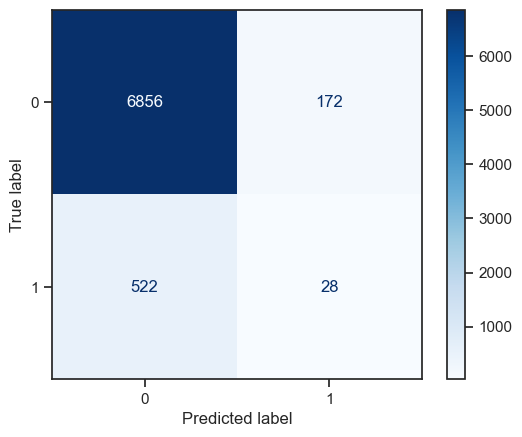

In [26]:
plot_confusion_matrix(best_model_cm["Random_Forest"])

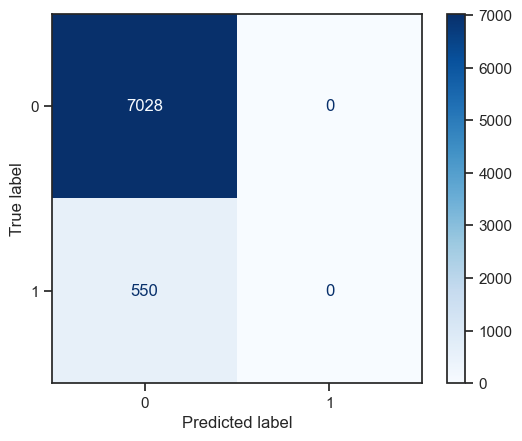

In [27]:
plot_confusion_matrix(best_model_cm["Logistic_Regression"])

To address the issue of imbalance in the dataset, I decided to employ a technique called SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous features). It is an extension of the original SMOTE algorithm that is designed to handle datasets with both numerical and categorical features. While SMOTE focuses on generating synthetic samples in the feature space of numerical attributes, SMOTENC takes into account the categorical variables as well.

In [28]:
categorical_col=[1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [29]:
classifiers = [
    ('Random_Forest', RandomForestClassifier(random_state=2)),
    ('Logistic_Regression', LogisticRegression(max_iter=1000)),
]

oversample = SMOTENC(categorical_col,random_state=8)
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

df_performance_results=pd.DataFrame(columns=["Accuracy","Balanced Accuracy","Sensitivity","Specificity","GM_score","F1-score"])
best_model_cm={}

for model_name, model in classifiers:
        
        model.fit(X_train_balanced, y_train_balanced)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)

        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred,pos_label=0)
        f1 = f1_score(y_test, y_pred)
        gm_score = sqrt(sensitivity*specificity)
        df_performance_results.loc[model_name]=[accuracy,balanced_accuracy,sensitivity,specificity,gm_score,f1]

        cm = confusion_matrix(y_test, y_pred)
        best_model_cm[model_name]=cm

In [30]:
df_performance_results

,Accuracy,Balanced Accuracy,Sensitivity,Specificity,GM_score,F1-score
Random_Forest,0.811164,0.550445,0.245455,0.855435,0.458225,0.158730
Logistic_Regression,0.628266,0.620267,0.610909,0.629624,0.620196,0.192605


After applying SMOTENC to address the class imbalance, I observed a slight improvement in the performance of the model. However, to further enhance the model's predictive capabilities, I have decided to proceed with hyperparameter tuning.

For hyperparameter tuning, I utilized Randomized Search CV, a technique that  explores different combinations of hyperparameters to find the optimal configuration.

In the Randomized Search CV, I specifically chose to maximize the F1 score as the evaluation metric.

In [31]:

def add_prefix_to_key(dictionary,prefix):
    updated_dict = {}
    for key in dictionary:
        updated_key = prefix + key
        updated_dict[updated_key] = dictionary[key]
    return updated_dict
      

param_grid_smot = {
     'smote__sampling_strategy':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,"auto"],
     }

param_grid_rf = {'class_weight':["balanced",None],
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 400]}
                   

param_grid_log={    
            'class_weight':["balanced",None],
                'C': [0.001, 0.01, 0.1, 1, 10],
                'max_iter': [1000,2000,3000]
                }


classifiers = [
    ('Random_Forest', RandomForestClassifier(random_state=2),add_prefix_to_key(param_grid_rf,"Random_Forest__")),
   ('Logistic_Regression', LogisticRegression(),add_prefix_to_key(param_grid_log,"Logistic_Regression__")),
]



df_performance_results=pd.DataFrame(columns=["Accuracy","Balanced Accuracy","Sensitivity","Specificity","GM_score","F1-score"])
best_model_cm={}
best_models_info={}

for model_name, model, parameters in classifiers:
        
        pipeline = Pipeline([
            ('smote', SMOTENC(categorical_col,random_state=8)),
            (model_name, model)
        ])
        stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

        param_grid=param_grid_smot.copy()
        param_grid.update(parameters)

        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            n_iter=5, 
            scoring='f1', 
            cv=stratified_kfold,  
            random_state=42
        )

        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        best_parameters = random_search.best_params_

        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred,pos_label=0)
        f1 = f1_score(y_test, y_pred)
        gm_score = sqrt(sensitivity*specificity)

        df_performance_results.loc[model_name]=[accuracy,balanced_accuracy,sensitivity,specificity,gm_score,f1]

        
        cm = confusion_matrix(y_test, y_pred)
        best_model_cm[model_name]=cm
        best_models_info[model_name]={"best_model":best_model,"best_parameters": best_parameters}




By tuning the hyperparameters of both SMOTENC and Random Forest models, I improved their performance.

In [32]:
df_performance_results

,Accuracy,Balanced Accuracy,Sensitivity,Specificity,GM_score,F1-score
Random_Forest,0.783848,0.605268,0.396364,0.814172,0.568074,0.210222
Logistic_Regression,0.806809,0.595022,0.347273,0.842772,0.540991,0.206934


Let's take a look at the best configuration of hyperparameter found

In [33]:
model=best_models_info["Random_Forest"]["best_model"][1]
best_models_info["Random_Forest"]

{'best_model': Pipeline(steps=[('smote',
                  SMOTENC(categorical_features=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11,
                                                12, 13, 14, 15, 16, 17, 18, 19],
                          random_state=8, sampling_strategy=0.5)),
                 ('Random_Forest',
                  RandomForestClassifier(class_weight='balanced', max_depth=20,
                                         max_features='sqrt', min_samples_leaf=4,
                                         min_samples_split=10, n_estimators=400,
                                         random_state=2))]),
 'best_parameters': {'smote__sampling_strategy': 0.5,
  'Random_Forest__n_estimators': 400,
  'Random_Forest__min_samples_split': 10,
  'Random_Forest__min_samples_leaf': 4,
  'Random_Forest__max_features': 'sqrt',
  'Random_Forest__max_depth': 20,
  'Random_Forest__class_weight': 'balanced',
  'Random_Forest__bootstrap': True}}

Let's save the best model on a pickle file

In [34]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Another approach to improve the model, particularly when dealing with unbalanced classes, is to adjust the classification threshold. By default, classification models use a threshold of 0.5, where probabilities above the threshold are classified as positive and below as negative. However, this threshold may not be optimal for unbalanced datasets.

To find the threshold that maximizes the F1 score, I performed threshold tuning. Instead of using the standard threshold of 0.5, I systematically varied the threshold and evaluated the F1 score at each point. Let's do this with the random forest model, which showed a higher f1 score.

In [35]:
thresh = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
max_f1=0
best_threshold=None
for value in thresh:
    y_prob=model.predict_proba(X_train)
    y_pred = (y_prob[:,1] >= value).astype(int)
    f1=f1_score(y_pred,y_train)
    if f1>max_f1:
        max_f1=f1
        best_threshold=value

y_prob_test=model.predict_proba(X_test)
y_pred_test = (y_prob_test[:,1] >= best_threshold).astype(int)
f1_test=f1_score(y_pred_test,y_test)
print(f"The best f1-score is: {f1_test}")
print(f"The threshold used is: {best_threshold}")



The best f1-score is: 0.2
The threshold used is: 0.6


There is no improvement in changing the threshold

# Model Explainability

In [36]:
# with open('model.pkl', 'rb') as file:
#     model = pickle.load(file)

To gain insights into the models and understand the importance of different features, I employed the SHAP (SHapley Additive exPlanations) library. SHAP utilizes a game theory approach to calculate the contributions of each feature towards the model's predictions.

In [48]:
forest=best_models_info["Random_Forest"]["best_model"][1]
explainer = shap.TreeExplainer(forest,random_state=3)
sampled_X_test=shap.sample(X_test, 1000) 
shap_values = explainer.shap_values(sampled_X_test)

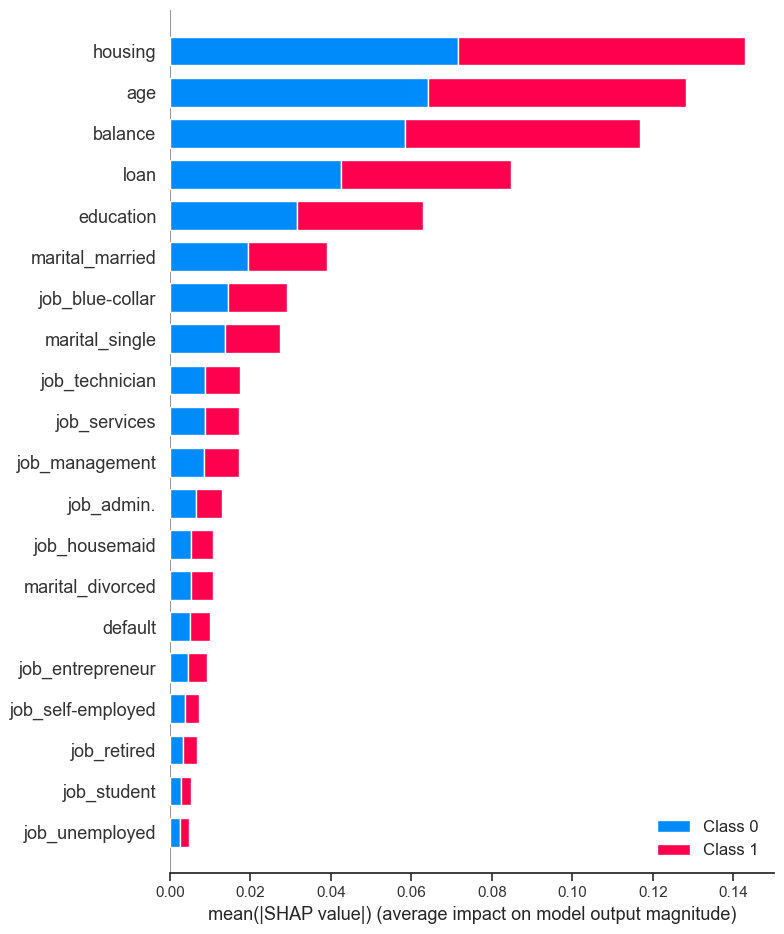

In [50]:
shap.summary_plot(shap_values, sampled_X_test)

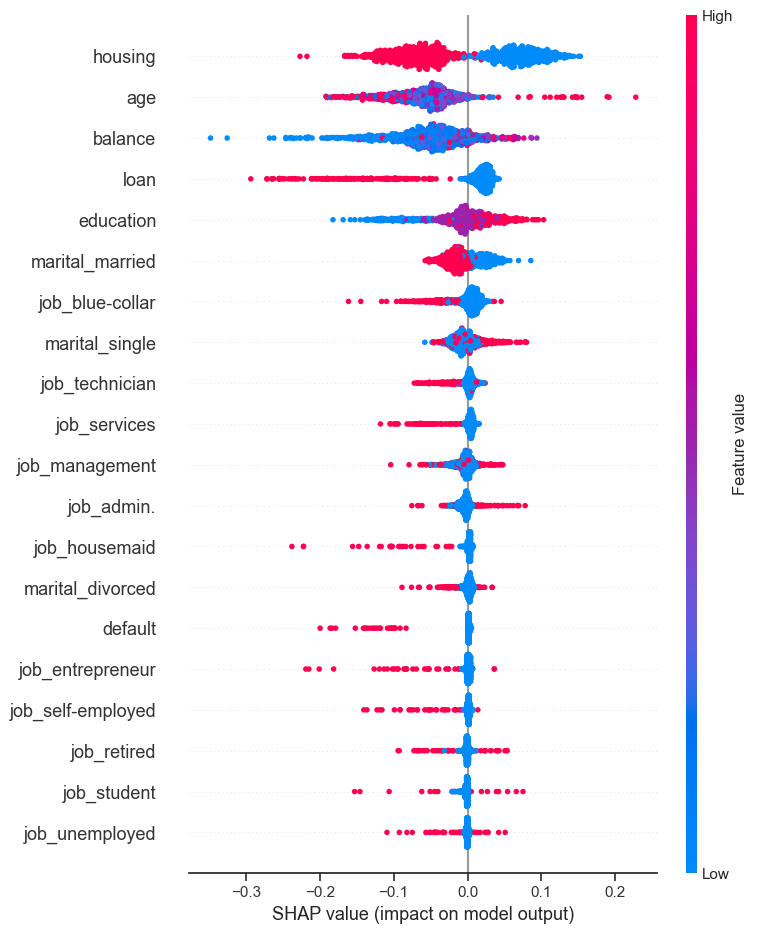

In [51]:
shap.summary_plot(shap_values[1], sampled_X_test)

Certain key factors significantly impact the likelihood of subscription: having no loans, age, balance, education level, and marital status. Not having any loans increases the probability of subscription, as does having a higher balance. Additionally, higher education levels and being unmarried positively influence the likelihood of subscription. These factors provide valuable insights for predicting subscription probabilities.

The web app to use the saved model to make predictions on new data is available at https://marketing-campaign-webpffe4u-4823u.streamlit.app/